In [2]:
import re
import numpy as np

def remove_docstrings(code):
    # 使用正则表达式匹配被 """ 包括的部分，并替换为空字符串
    cleaned_code = re.sub(r'""".*?"""', '', code, flags=re.DOTALL)
    cleaned_code = re.sub(r"'''.*?'''", '', cleaned_code, flags=re.DOTALL)
    return cleaned_code

def cosine_similarity_matrix(nl_features, code_features):
    # 计算每个特征向量的范数
    nl_norms = np.linalg.norm(nl_features, axis=1, keepdims=True)
    code_norms = np.linalg.norm(code_features, axis=1, keepdims=True)
    
    # 计算点积
    dot_product = np.dot(nl_features, code_features.T)
    
    # 计算余弦相似度矩阵
    cosine_similarity = dot_product / (nl_norms * code_norms.T)
    
    return cosine_similarity

In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""


In [4]:
def remove_padding_intervals(tokenized_id_data):
    """
    移除 tokenized_id_data 中所有 `[0,0]` 区间（除非它是开头的第一个区间）。

    Args:
    - tokenized_id_data (list of lists): 包含区间的列表，每个区间是一个长度为 2 的列表。

    Returns:
    - filtered_data (list of lists): 移除 `[0,0]` 填充数据后的区间列表。
    """
    if isinstance(tokenized_id_data, np.ndarray):
        tokenized_id_data = tokenized_id_data.tolist()  # 将 NumPy 数组转换为列表
    # 处理的结果列表
    filtered_data = []

    # 保留开头的 `[0,0]` 区间（如果存在）
    if tokenized_id_data and tokenized_id_data[0] == [0,0]:
        filtered_data.append([0,0])
        start_index = 1  # 从第二个元素开始检查
    else:
        start_index = 0

    # 处理剩余的区间
    for interval in tokenized_id_data[start_index:]:
        if interval != [0,0]:  # 仅添加非 `[0,0]` 区间
            filtered_data.append(interval)

    return filtered_data

In [5]:
import json
def load_loss_data(filepath):
    with open(filepath, 'r') as file:
        data = json.load(file)
    return np.array(data)

In [6]:
with open("/home/yiming/cophi/projects/fork/CodeBERT/GraphCodeBERT/codesearch/dataset/python/train.jsonl", "r") as f:
    train_dataset = [json.loads(line) for line in f.readlines()]


In [7]:
import json
import os

# 文件路径
json_file_path = '/home/yiming/cophi/training_dynamic/gcb_tokens_temp/Model/Epoch_1/tokenized_code_tokens_train.json'

# 读取JSON文件
with open(json_file_path, 'r', encoding='utf-8') as f:
    code_tokens_data = json.load(f)

# 文件路径
json_file_path = '/home/yiming/cophi/training_dynamic/gcb_tokens_temp/Model/Epoch_1/tokenized_comment_tokens_train.json'


# 读取JSON文件
with open(json_file_path, 'r', encoding='utf-8') as f:
    nl_tokens_data = json.load(f)

In [8]:
# 预设10种高对比度颜色
high_contrast_colors = [
    "#FF0000", "#00FF00", "#0000FF", "#FF00FF", "#00FFFF",
    "#800000", "#008000", "#000080", "#808080", "#FFA500"
]

In [15]:
import json
input_path = "/home/yiming/cophi/projects/fork/CodeBERT/GraphCodeBERT/codesearch/auto_labelling/sorted_labelling_sample_api_student_conf_sorted.jsonl"
idx_list = []
match_list = []

with open(input_path, 'r', encoding='utf-8') as file:
    for line in file:
        line = line.strip().rstrip(',')  # 去除行末的逗号
        json_obj = json.loads(line)
        idx_list.append(json_obj['idx'])
        match_list.append(json_obj['match'])

In [110]:
indice = 10685

In [111]:
# 提取match_list中对应索引的值
match_values = match_list[indice]

# 输出结果
print("Corresponding values in match_list:", match_values)
# 初始化结果列表
comment_list = []
code_list = []

# 遍历 match_values，处理每个 comment 和 code 的区间
for match in match_values:  # 假设 match_values 的结构是 [[...]]
    comment_intervals, code_intervals = match

    # 展开 comment 的所有索引
    comment_indices = []
    for start, end in zip(comment_intervals[::2], comment_intervals[1::2]):
        comment_indices.extend(range(start, end + 1))
    comment_list.append(comment_indices)

    # 展开 code 的所有索引
    code_indices = []
    for start, end in zip(code_intervals[::2], code_intervals[1::2]):
        code_indices.extend(range(start, end + 1))
    code_list.append(code_indices)

# 输出结果
print("Comment indices list:", comment_list)
print("Code indices list:", code_list)


Corresponding values in match_list: [[[0, 0], [1, 5]], [[2, 3], [7, 7, 43, 43]], [[5, 5, 9, 9, 11, 11], [18, 18, 26, 26, 46, 47, 54, 55]]]
Comment indices list: [[0], [2, 3], [5, 9, 11]]
Code indices list: [[1, 2, 3, 4, 5], [7, 43], [18, 26, 46, 47, 54, 55]]


In [112]:
import numpy as np
from collections import deque
from IPython.display import display, HTML


token_list1 = nl_tokens_data[idx_list[indice]][1:]
doc_snippet = train_dataset[idx_list[indice]]["docstring"]
# 将 token 与对应的贡献值配对，并去掉 token 中的 "Ġ" 符号
tokens_with_contributions = deque([(token.replace("Ġ", ""), 1.0) for token in token_list1])

# 为每个 comment_list 的索引组指定颜色
color_map = {}
for i, indices in enumerate(comment_list):
    color = high_contrast_colors[i % len(high_contrast_colors)]  # 循环使用颜色
    for idx in indices:
        color_map[idx] = color

# 生成HTML带字体大小和颜色调整的输出
html_string = "<pre>"
buffer = ""
current_index = 0  # 追踪 code_snippet 中字符的索引位置

# 遍历原始代码片段的每个字符
for char in doc_snippet:
    if char == "\n":
        # 遇到换行符则添加 <br> 标签并清空缓冲区
        html_string += buffer + "<br>"
        buffer = ""
    elif tokens_with_contributions:
        # 获取当前 token 和其贡献值
        token, _ = tokens_with_contributions[0]
        buffer += char

        # 逐字符匹配：检查 token 是否与 buffer 逐字符匹配
        if buffer == token:
            color = color_map.get(current_index, "black")  # 如果索引有颜色则应用，否则默认为黑色
            html_string += f'<span style="color: {color};">{buffer}</span>'
            buffer = ""  # 清空缓冲区
            tokens_with_contributions.popleft()  # 移除已匹配的 token
            current_index += 1
        elif not token.startswith(buffer):
            # 如果缓冲区字符序列和当前 token 不匹配，将缓冲区第一个字符添加到 HTML 并继续逐字符匹配
            color = color_map.get(current_index, "black")
            html_string += f'<span style="color: {color};">{buffer[0]}</span>'
            buffer = buffer[1:]      
        
    else:
        # 如果没有更多 token 需要匹配，默认输出字符
        color = color_map.get(current_index, "black")
        html_string += f'<span style="color: {color};">{char}</span>'

html_string += buffer  # 添加剩余的缓冲区内容
html_string += "</pre>"

In [113]:
# 假设我们有原始代码片段和分词后的 tokens（包含缩进和换行）
code_snippet = remove_docstrings(train_dataset[idx_list[indice]]["code"])
token_list2 = code_tokens_data[idx_list[indice]][1:]


# 将 token 与对应的贡献值配对，并去掉 token 中的 "Ġ" 符号
tokens_with_contributions = deque([(token.replace("Ġ", ""), 1.0) for token in token_list2])

# 为每个 code_list 的索引组指定颜色
color_map = {}
for i, indices in enumerate(code_list):
    color = high_contrast_colors[i % len(high_contrast_colors)]  # 循环使用颜色
    for idx in indices:
        color_map[idx] = color

# 生成HTML带颜色调整的输出
formatted_output = "<pre>"
buffer = ""
current_index = 0  # 追踪 code_snippet 中字符的索引位置

# 遍历原始代码片段的每个字符
for char in code_snippet:
    if char == "\n":
        # 遇到换行符则添加 <br> 标签并清空缓冲区
        formatted_output += buffer + "<br>"
        buffer = ""
    elif tokens_with_contributions:
        # 获取当前 token 和其贡献值
        token, _ = tokens_with_contributions[0]
        buffer += char

        # 逐字符匹配：检查 token 是否与 buffer 逐字符匹配
        if buffer == token:
            color = color_map.get(current_index, "black")  # 如果索引有颜色则应用，否则默认为黑色
            formatted_output += f'<span style="color: {color};">{buffer}</span>'
            buffer = ""  # 清空缓冲区
            tokens_with_contributions.popleft()  # 移除已匹配的 token
            current_index += 1
        elif not token.startswith(buffer):
            # 如果缓冲区字符序列和当前 token 不匹配，将缓冲区第一个字符添加到 HTML 并继续逐字符匹配
            color = color_map.get(current_index, "black")
            formatted_output += f'<span style="color: {color};">{buffer[0]}</span>'
            buffer = buffer[1:]      
        
    else:
        # 如果没有更多 token 需要匹配，默认输出字符
        color = color_map.get(current_index, "black")
        formatted_output += f'<span style="color: {color};">{char}</span>'

formatted_output += buffer  # 添加剩余的缓冲区内容
formatted_output += "</pre>"

# 在Jupyter Notebook中显示带有字体大小和颜色调整的文本
display(HTML(html_string))
# 在Jupyter Notebook中显示带有颜色调整的文本
display(HTML(formatted_output))

In [2]:
import json
# 读取tokenized_id_train.json文件
with open('/home/yiming/cophi/training_dynamic/features/tokenized_id_train.json', 'r') as f:
    tokenized_id_data = json.load(f)

In [39]:
print(remove_docstrings(train_dataset[1]["code"]))
print(tokenized_id_data[1])
code_tokens = train_dataset[1]["code_tokens"]
for i, token in enumerate(code_tokens):
    print(f"Index {i}: {token}")

def ensure_dir(d):
    
    if not os.path.exists(d):
        try:
            os.makedirs(d)
        except OSError as oe:
            # should not happen with os.makedirs
            # ENOENT: No such file or directory
            if os.errno == errno.ENOENT:
                msg = twdd()
                return msg.format(d)
            else:
                msg = twdd()
                return msg.format(d, oe.strerror)
[[0, 0], [0, 1], [1, 4], [4, 5], [5, 6], [6, 7], [7, 8], [8, 9], [9, 10], [10, 11], [11, 12], [12, 13], [13, 14], [14, 15], [15, 16], [16, 17], [17, 18], [18, 19], [19, 20], [20, 21], [21, 22], [22, 23], [23, 26], [26, 27], [27, 28], [28, 29], [29, 30], [30, 34], [34, 35], [35, 37], [37, 38], [38, 39], [39, 40], [40, 41], [41, 43], [43, 44], [44, 46], [46, 47], [47, 50], [50, 51], [51, 52], [52, 53], [53, 55], [55, 56], [56, 144], [144, 145], [145, 146], [146, 147], [147, 148], [148, 149], [149, 150], [150, 151], [151, 152], [152, 153], [153, 154], [154, 155], [155, 15

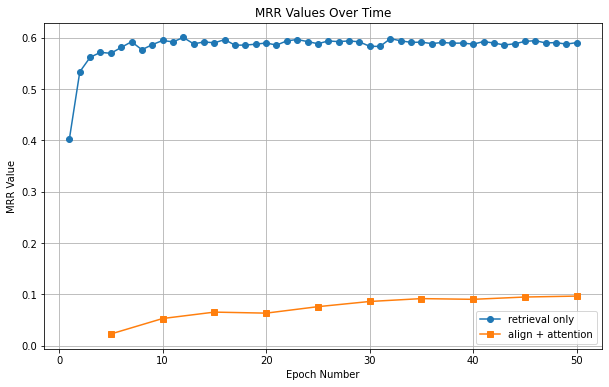

MRR values from train2.log: [0.4035, 0.5336, 0.562, 0.5716, 0.5697, 0.5812, 0.5923, 0.5767, 0.5866, 0.5947, 0.592, 0.6006, 0.5881, 0.5919, 0.5902, 0.5964, 0.5855, 0.5858, 0.5875, 0.5899, 0.5857, 0.594, 0.5966, 0.5926, 0.5884, 0.5938, 0.5925, 0.5939, 0.5921, 0.5834, 0.5832, 0.5983, 0.5941, 0.591, 0.5915, 0.5886, 0.5909, 0.5894, 0.5897, 0.5875, 0.5926, 0.5898, 0.5859, 0.5883, 0.5929, 0.5944, 0.5899, 0.5906, 0.5876, 0.5906]
MRR values from train.log (first 10 evaluations): [0.0229, 0.053, 0.0655, 0.0635, 0.0761, 0.0862, 0.0918, 0.0904, 0.0949, 0.0967]


In [3]:
import re
import matplotlib.pyplot as plt

# Read the log files
mrr_values_1 = []
mrr_values_2 = []

# Read first log file (retrieval only)
with open('/home/yiming/cophi/projects/fork/CodeBERT/GraphCodeBERT/codesearch/train2.log', 'r') as f:
    for line in f:
        if 'eval_mrr = ' in line:
            match = re.search(r'eval_mrr = ([\d.]+)', line)
            if match:
                mrr_value = float(match.group(1))
                mrr_values_1.append(mrr_value)

# Read second log file (align + attention)
with open('/home/yiming/cophi/projects/fork/CodeBERT/GraphCodeBERT/codesearch/train_simple_aa.log', 'r') as f:
    for line in f:
        if 'eval_mrr = ' in line:
            match = re.search(r'eval_mrr = ([\d.]+)', line)
            if match:
                mrr_value = float(match.group(1))
                mrr_values_2.append(mrr_value)
            if len(mrr_values_2) >= 10:  # Only keep first 10 evaluations
                break

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(mrr_values_1) + 1), mrr_values_1, marker='o', label='retrieval only')
plt.plot([5*i for i in range(1, len(mrr_values_2) + 1)], mrr_values_2, marker='s', label='align + attention')
plt.xlabel('Epoch Number')
plt.ylabel('MRR Value')
plt.title('MRR Values Over Time')
plt.grid(True)
plt.legend()
plt.show()

# Print the values
print("MRR values from train2.log:", mrr_values_1)
print("MRR values from train.log (first 10 evaluations):", mrr_values_2)


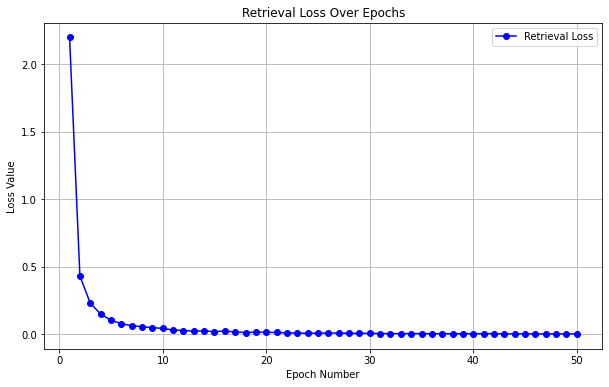

Retrieval loss values: [2.19785, 0.42918, 0.2299, 0.14895, 0.10322, 0.07746, 0.06295, 0.05527, 0.04836, 0.04254, 0.0305, 0.0268, 0.02203, 0.024, 0.01851, 0.02328, 0.01613, 0.01225, 0.01452, 0.0144, 0.01235, 0.00892, 0.00834, 0.00678, 0.00718, 0.00768, 0.00896, 0.0058, 0.00562, 0.00657, 0.00456, 0.00459, 0.00345, 0.00456, 0.00375, 0.00282, 0.00404, 0.00263, 0.00407, 0.00286, 0.00336, 0.00373, 0.00135, 0.00242, 0.00191, 0.00198, 0.00166, 0.00155, 0.0024, 0.00174]


In [11]:
import re
import matplotlib.pyplot as plt

# Read the log file
retrieval_losses = []

# Read train.log file
with open('/home/yiming/cophi/projects/fork/CodeBERT/GraphCodeBERT/codesearch/train2.log', 'r') as f:
    for line in f:
        if 'average losses' in line:
            match = re.search(r'Retrieval Loss: ([\d.]+)', line)
            if match:
                loss_value = float(match.group(1))
                retrieval_losses.append(loss_value)

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(retrieval_losses) + 1), retrieval_losses, marker='o', color='blue', label='Retrieval Loss')
plt.xlabel('Epoch Number')
plt.ylabel('Loss Value')
plt.title('Retrieval Loss Over Epochs')
plt.grid(True)
plt.legend()
plt.show()

# Print the values
print("Retrieval loss values:", retrieval_losses)


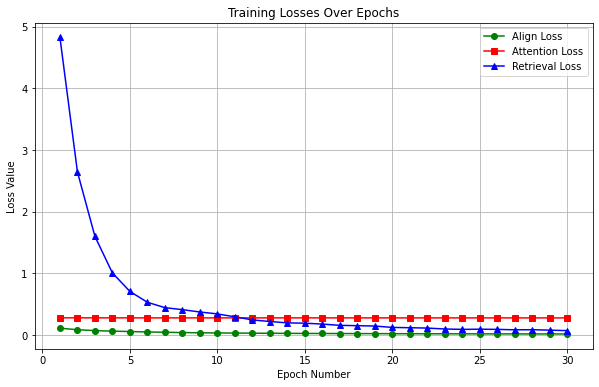

Align loss values: [0.1127371875, 0.087173125, 0.073184375, 0.06456, 0.05793375, 0.051679375, 0.0461871875, 0.04141125, 0.0378621875, 0.0351853125, 0.0330921875, 0.0313675, 0.029873125, 0.0287071875, 0.0275871875, 0.0264671875, 0.0257115625, 0.02485625, 0.0240359375, 0.0233765625, 0.0227775, 0.02227625, 0.0217046875, 0.021158125, 0.0207065625, 0.0202146875, 0.019811875, 0.0193640625, 0.0190028125, 0.018641875]
Attention loss values: [0.2805390625, 0.280203125, 0.2799675, 0.2797509375, 0.2795996875, 0.2794759375, 0.2794125, 0.279383125, 0.279414375, 0.2794771875, 0.2795096875, 0.2795015625, 0.279473125, 0.27942625, 0.2793921875, 0.27934125, 0.2793021875, 0.279265, 0.2792475, 0.2792203125, 0.27918, 0.2791409375, 0.279109375, 0.2790734375, 0.2790334375, 0.278994375, 0.278966875, 0.2789425, 0.2789015625, 0.278869375]
Retrieval loss values: [4.82455, 2.64499, 1.60087, 1.00783, 0.70851, 0.53227, 0.44521, 0.41263, 0.37484, 0.34398, 0.29667, 0.24677, 0.22061, 0.19864, 0.19328, 0.17898, 0.15843

In [3]:
import re
import matplotlib.pyplot as plt

# Initialize lists to store different loss values
align_losses = []
attention_losses = []
retrieval_losses = []

# Read train.log file
with open('/home/yiming/cophi/projects/fork/CodeBERT/GraphCodeBERT/codesearch/train.log', 'r') as f:
    first_record = True
    for line in f:
        if 'average losses' in line:
            # Extract all three loss values
            align_match = re.search(r'Align Loss: ([\d.]+)', line)
            attention_match = re.search(r'Attention Loss: ([\d.]+)', line)
            retrieval_match = re.search(r'Retrieval Loss: ([\d.]+)', line)
            
            if align_match and attention_match and retrieval_match:
                align_loss = float(align_match.group(1)) / 32
                attention_loss = float(attention_match.group(1)) / 32
                retrieval_loss = float(retrieval_match.group(1))
                
                align_losses.append(align_loss)
                attention_losses.append(attention_loss)
                retrieval_losses.append(retrieval_loss)

# Create the plot
plt.figure(figsize=(10, 6))

# Plot all three losses on the same graph
plt.plot(range(1, len(align_losses) + 1), align_losses, marker='o', color='green', label='Align Loss')
plt.plot(range(1, len(attention_losses) + 1), attention_losses, marker='s', color='red', label='Attention Loss')
plt.plot(range(1, len(retrieval_losses) + 1), retrieval_losses, marker='^', color='blue', label='Retrieval Loss')

plt.xlabel('Epoch Number')
plt.ylabel('Loss Value')
plt.title('Training Losses Over Epochs')
plt.grid(True)
plt.legend()
plt.show()

# Print the values
print("Align loss values:", align_losses)
print("Attention loss values:", attention_losses)
print("Retrieval loss values:", retrieval_losses)

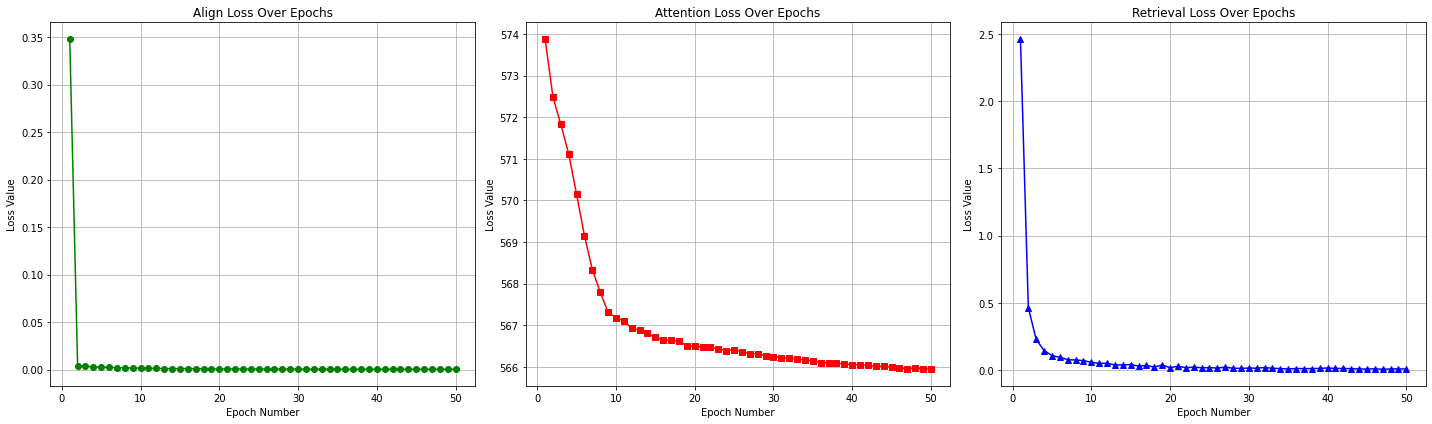

Align loss values: [0.34803, 0.00406, 0.00338, 0.00277, 0.00231, 0.00231, 0.00189, 0.0017, 0.00157, 0.00161, 0.00118, 0.00127, 0.00093, 0.00092, 0.00086, 0.00093, 0.00083, 0.00076, 0.00064, 0.00073, 0.00055, 0.00058, 0.00055, 0.00058, 0.00057, 0.00051, 0.00047, 0.00047, 0.00043, 0.00042, 0.00034, 0.00038, 0.00043, 0.00038, 0.00037, 0.00033, 0.0003, 0.00031, 0.00033, 0.0003, 0.00029, 0.00028, 0.00028, 0.00024, 0.00028, 0.00025, 0.00024, 0.00027, 0.00029, 0.00028]
Attention loss values: [573.88032, 572.48096, 571.82464, 571.1168, 570.14432, 569.1504, 568.33824, 567.7952, 567.31168, 567.1872, 567.0976, 566.9344, 566.87808, 566.80608, 566.7072, 566.65184, 566.63744, 566.62272, 566.50496, 566.49472, 566.4832, 566.47616, 566.43072, 566.392, 566.40608, 566.37056, 566.31488, 566.31744, 566.27168, 566.24608, 566.22336, 566.21184, 566.1872, 566.16768, 566.1456, 566.10368, 566.09664, 566.08384, 566.07776, 566.05024, 566.05312, 566.03808, 566.0128, 566.01728, 565.99936, 565.968, 565.95872, 565.968

In [17]:
import re
import matplotlib.pyplot as plt

# Initialize lists to store different loss values
align_losses = []
attention_losses = []
retrieval_losses = []

# Read train.log file
with open('/home/yiming/cophi/projects/fork/CodeBERT/GraphCodeBERT/codesearch/train.log', 'r') as f:
    for line in f:
        if 'average losses' in line:
            # Extract all three loss values
            align_match = re.search(r'Align Loss: ([\d.]+)', line)
            attention_match = re.search(r'Attention Loss: ([\d.]+)', line)
            retrieval_match = re.search(r'Retrieval Loss: ([\d.]+)', line)
            
            if align_match and attention_match and retrieval_match:
                align_loss = float(align_match.group(1))
                attention_loss = float(attention_match.group(1)) * 32
                retrieval_loss = float(retrieval_match.group(1))
                
                align_losses.append(align_loss)
                attention_losses.append(attention_loss)
                retrieval_losses.append(retrieval_loss)

# Create three subplots
plt.figure(figsize=(20, 6))

# Plot align loss
plt.subplot(1, 3, 1)
plt.plot(range(1, len(align_losses) + 1), align_losses, marker='o', color='green')
plt.xlabel('Epoch Number')
plt.ylabel('Loss Value')
plt.title('Align Loss Over Epochs')
plt.grid(True)

# Plot attention loss
plt.subplot(1, 3, 2)
plt.plot(range(1, len(attention_losses) + 1), attention_losses, marker='s', color='red')
plt.xlabel('Epoch Number')
plt.ylabel('Loss Value') 
plt.title('Attention Loss Over Epochs')
plt.grid(True)

# Plot retrieval loss
plt.subplot(1, 3, 3)
plt.plot(range(1, len(retrieval_losses) + 1), retrieval_losses, marker='^', color='blue')
plt.xlabel('Epoch Number')
plt.ylabel('Loss Value')
plt.title('Retrieval Loss Over Epochs')
plt.grid(True)

plt.tight_layout()
plt.show()

# Print the values
print("Align loss values:", align_losses)
print("Attention loss values:", attention_losses) 
print("Retrieval loss values:", retrieval_losses)

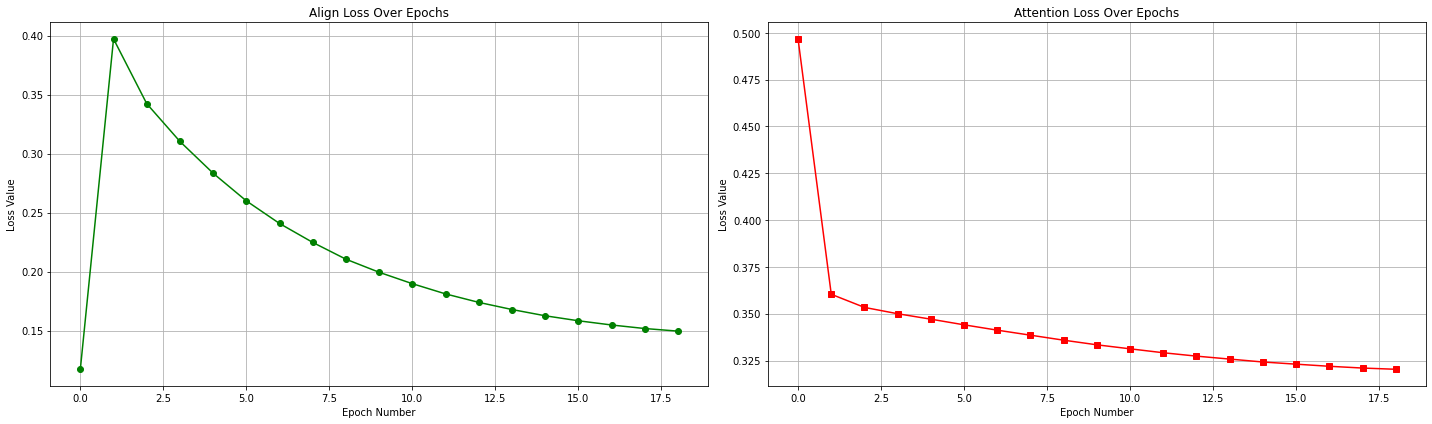

Align loss values: [0.1171446875, 0.3971659375, 0.342254375, 0.3102534375, 0.28331125, 0.259881875, 0.2407121875, 0.2246740625, 0.2104425, 0.199359375, 0.189691875, 0.1810303125, 0.1738509375, 0.1678009375, 0.162493125, 0.158263125, 0.154685625, 0.15168625, 0.1494853125]
Attention loss values: [0.4967371875, 0.3603659375, 0.353359375, 0.349979375, 0.3470709375, 0.344055, 0.3412059375, 0.338525625, 0.3358528125, 0.33338, 0.331239375, 0.3291446875, 0.3273346875, 0.3257628125, 0.3242021875, 0.323044375, 0.3219159375, 0.3209771875, 0.320315]


In [2]:
import re
import matplotlib.pyplot as plt

# Initialize lists to store different loss values
align_losses = []
attention_losses = []

# # Read first log file (train_aaonly3.log)
# with open('/home/yiming/cophi/projects/fork/CodeBERT/GraphCodeBERT/codesearch/train_aaonly3.log', 'r') as f:
#     for line in f:
#         if 'average losses' in line:
#             # Extract align and attention loss values
#             align_match = re.search(r'Align Loss: ([\d.]+)', line)
#             attention_match = re.search(r'Attention Loss: ([\d.]+)', line)
            
#             if align_match and attention_match:
#                 align_loss = float(align_match.group(1))
#                 attention_loss = float(attention_match.group(1)) / 32
                
#                 align_losses.append(align_loss)
#                 attention_losses.append(attention_loss)

# Initialize with epoch 0 values
align_losses = [3.74863/32]  # Initial value for epoch 0
attention_losses = [15.89559/32]  # Initial value for epoch 0

# Read second log file (train.log)
with open('/home/yiming/cophi/projects/fork/CodeBERT/GraphCodeBERT/codesearch/trainhp.log', 'r') as f:
    for line in f:
        if 'average losses' in line:
            # Extract align and attention loss values
            align_match = re.search(r'Align Loss: ([\d.]+)', line)
            attention_match = re.search(r'Attention Loss: ([\d.]+)', line)
            
            if align_match and attention_match:
                align_loss = float(align_match.group(1))
                attention_loss = float(attention_match.group(1))
                
                align_losses.append(align_loss/32)
                attention_losses.append(attention_loss/32)

# align_losses = [0.1171446875, 0.0463196875, 0.0438965625, 0.0436309375, 0.0434084375, 0.04301375, 0.0429175, 0.0422734375, 0.0469959375, 0.0429190625, 0.0423384375, 0.041436875, 0.04144, 0.041045625, 0.0403553125, 0.040015, 0.039765, 0.040420625, 0.0394725, 0.0389059375, 0.038860625, 0.0387353125, 0.03842875, 0.038445625, 0.0385546875, 0.038055625, 0.0378615625, 0.0378090625, 0.0372396875, 0.0369896875, 0.0367353125, 0.036688125, 0.03619, 0.0360128125, 0.0356559375, 0.0357625, 0.035719375, 0.03542125, 0.0363765625, 0.034894375, 0.035313125, 0.034900625, 0.0346084375, 0.0352265625, 0.034606875, 0.0344978125, 0.034240625, 0.034308125, 0.0344565625, 0.0343309375, 0.0344646875]
# attention_losses = [0.4967371875, 0.4822334375, 0.466589375, 0.4600528125, 0.4541415625, 0.448606875, 0.4431821875, 0.4383315625, 0.438024375, 0.4306909375, 0.4258125, 0.420615, 0.4181103125, 0.4152209375, 0.411811875, 0.407391875, 0.4038115625, 0.4015490625, 0.397648125, 0.3956659375, 0.39233625, 0.3894284375, 0.3876875, 0.3849859375, 0.3831153125, 0.3813790625, 0.379216875, 0.37726625, 0.3753275, 0.373765625, 0.3719071875, 0.3709440625, 0.3694434375, 0.367656875, 0.3665228125, 0.3648709375, 0.363686875, 0.3626884375, 0.3621453125, 0.3613309375, 0.360165625, 0.3593640625, 0.358921875, 0.3582034375, 0.3579515625, 0.3572690625, 0.356805, 0.3566090625, 0.355855, 0.356631875, 0.3559140625]

# Create two subplots
plt.figure(figsize=(20, 6))

# Plot align loss
plt.subplot(1, 2, 1)
plt.plot(range(0, len(align_losses)), align_losses, marker='o', color='green')  # Start from epoch 0
plt.xlabel('Epoch Number')
plt.ylabel('Loss Value')
plt.title('Align Loss Over Epochs')
plt.grid(True)

# Plot attention loss
plt.subplot(1, 2, 2)
plt.plot(range(0, len(attention_losses)), attention_losses, marker='s', color='red')  # Start from epoch 0
plt.xlabel('Epoch Number')
plt.ylabel('Loss Value') 
plt.title('Attention Loss Over Epochs')
plt.grid(True)

plt.tight_layout()
plt.show()

# Print the values
print("Align loss values:", align_losses)
print("Attention loss values:", attention_losses)

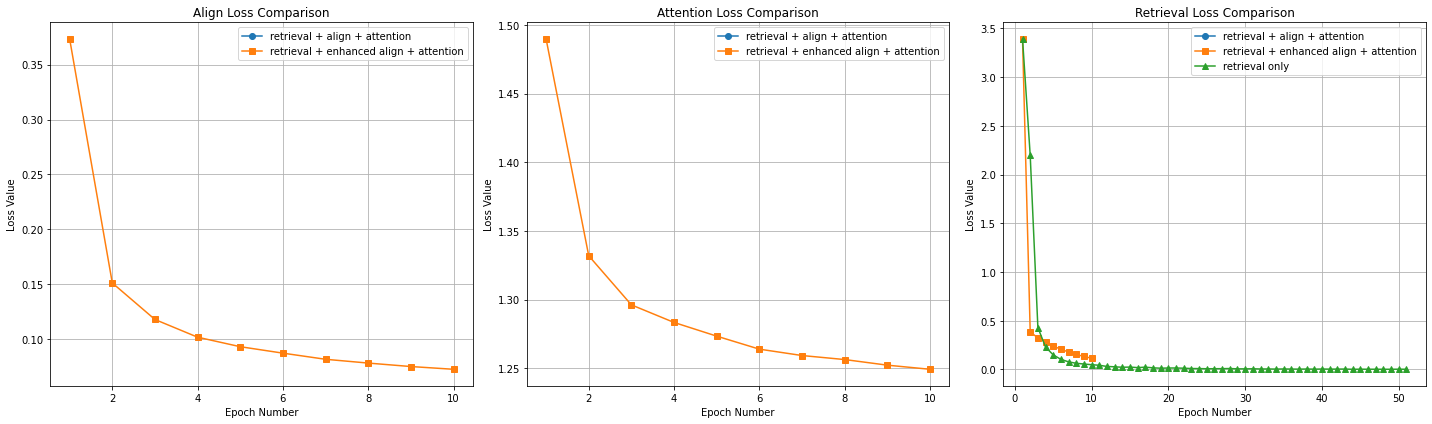

train_aa.log values:
Align loss values: [0.37342]
Attention loss values: [1.48974]
Retrieval loss values: [3.3928]

train_aaalign.log values:
Align loss values: [0.37342, 0.15107, 0.11778, 0.10166, 0.09299, 0.08712, 0.08153, 0.07807, 0.07492, 0.07242]
Attention loss values: [1.48974, 1.33192, 1.2962, 1.28341, 1.27345, 1.26398, 1.25934, 1.25641, 1.25233, 1.24933]
Retrieval loss values: [3.3928, 0.38429, 0.32454, 0.27897, 0.23953, 0.20686, 0.1784, 0.15348, 0.13327, 0.11462]

train2.log values:
Retrieval loss values: [3.3928, 2.19785, 0.42918, 0.2299, 0.14895, 0.10322, 0.07746, 0.06295, 0.05527, 0.04836, 0.04254, 0.0305, 0.0268, 0.02203, 0.024, 0.01851, 0.02328, 0.01613, 0.01225, 0.01452, 0.0144, 0.01235, 0.00892, 0.00834, 0.00678, 0.00718, 0.00768, 0.00896, 0.0058, 0.00562, 0.00657, 0.00456, 0.00459, 0.00345, 0.00456, 0.00375, 0.00282, 0.00404, 0.00263, 0.00407, 0.00286, 0.00336, 0.00373, 0.00135, 0.00242, 0.00191, 0.00198, 0.00166, 0.00155, 0.0024, 0.00174]


In [3]:
import re
import matplotlib.pyplot as plt

# Initialize lists to store different loss values for both logs
align_losses_aa = [0.37342]
attention_losses_aa = [1.48974] 
retrieval_losses_aa = [3.39280]

align_losses_aaalign = [0.37342]
attention_losses_aaalign = [1.48974]
retrieval_losses_aaalign = [3.39280]

retrieval_losses_train = [3.39280] # Add train2.log retrieval losses

# Read train.log file
with open('/home/yiming/cophi/projects/fork/CodeBERT/GraphCodeBERT/codesearch/train.log', 'r') as f:
    first_record = True
    for line in f:
        if 'average losses' in line:
            # Extract all three loss values
            align_match = re.search(r'Align Loss: ([\d.]+)', line)
            attention_match = re.search(r'Attention Loss: ([\d.]+)', line)
            retrieval_match = re.search(r'Retrieval Loss: ([\d.]+)', line)
            
            if align_match and attention_match and retrieval_match:
                align_loss = float(align_match.group(1))
                attention_loss = float(attention_match.group(1))
                retrieval_loss = float(retrieval_match.group(1))
                
                # Replace first attention loss with 1.40
                if first_record:
                    attention_loss = 1.40
                    first_record = False
                
                align_losses_aa.append(align_loss)
                attention_losses_aa.append(attention_loss)
                retrieval_losses_aa.append(retrieval_loss)

# Read train_aaalign.log file
with open('/home/yiming/cophi/projects/fork/CodeBERT/GraphCodeBERT/codesearch/train_aaalign.log', 'r') as f:
    for line in f:
        if 'average losses' in line:
            # Extract all three loss values
            align_match = re.search(r'Align Loss: ([\d.]+)', line)
            attention_match = re.search(r'Attention Loss: ([\d.]+)', line)
            retrieval_match = re.search(r'Retrieval Loss: ([\d.]+)', line)
            
            if align_match and attention_match and retrieval_match:
                align_loss = float(align_match.group(1))
                attention_loss = float(attention_match.group(1))
                retrieval_loss = float(retrieval_match.group(1))
                
                align_losses_aaalign.append(align_loss)
                attention_losses_aaalign.append(attention_loss)
                retrieval_losses_aaalign.append(retrieval_loss)

# Read train2.log file
with open('/home/yiming/cophi/projects/fork/CodeBERT/GraphCodeBERT/codesearch/train2.log', 'r') as f:
    for line in f:
        if 'average losses' in line:
            # Extract retrieval loss value
            retrieval_match = re.search(r'Retrieval Loss: ([\d.]+)', line)
            
            if retrieval_match:
                retrieval_loss = float(retrieval_match.group(1))
                retrieval_losses_train.append(retrieval_loss)

# Create three subplots for comparing each type of loss
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

# Plot Align Loss comparison
ax1.plot(range(1, len(align_losses_aa) + 1), align_losses_aa, marker='o', label='retrieval + align + attention')
ax1.plot(range(1, len(align_losses_aaalign) + 1), align_losses_aaalign, marker='s', label='retrieval + enhanced align + attention')
ax1.set_xlabel('Epoch Number')
ax1.set_ylabel('Loss Value')
ax1.set_title('Align Loss Comparison')
ax1.grid(True)
ax1.legend()

# Plot Attention Loss comparison
ax2.plot(range(1, len(attention_losses_aa) + 1), attention_losses_aa, marker='o', label='retrieval + align + attention')
ax2.plot(range(1, len(attention_losses_aaalign) + 1), attention_losses_aaalign, marker='s', label='retrieval + enhanced align + attention')
ax2.set_xlabel('Epoch Number')
ax2.set_ylabel('Loss Value')
ax2.set_title('Attention Loss Comparison')
ax2.grid(True)
ax2.legend()

# Plot Retrieval Loss comparison
ax3.plot(range(1, len(retrieval_losses_aa) + 1), retrieval_losses_aa, marker='o', label='retrieval + align + attention')
ax3.plot(range(1, len(retrieval_losses_aaalign) + 1), retrieval_losses_aaalign, marker='s', label='retrieval + enhanced align + attention')
ax3.plot(range(1, len(retrieval_losses_train) + 1), retrieval_losses_train, marker='^', label='retrieval only')
ax3.set_xlabel('Epoch Number')
ax3.set_ylabel('Loss Value')
ax3.set_title('Retrieval Loss Comparison')
ax3.grid(True)
ax3.legend()

plt.tight_layout()
plt.show()

# Print the values
print("train_aa.log values:")
print("Align loss values:", align_losses_aa)
print("Attention loss values:", attention_losses_aa)
print("Retrieval loss values:", retrieval_losses_aa)
print("\ntrain_aaalign.log values:")
print("Align loss values:", align_losses_aaalign)
print("Attention loss values:", attention_losses_aaalign)
print("Retrieval loss values:", retrieval_losses_aaalign)
print("\ntrain2.log values:")
print("Retrieval loss values:", retrieval_losses_train)

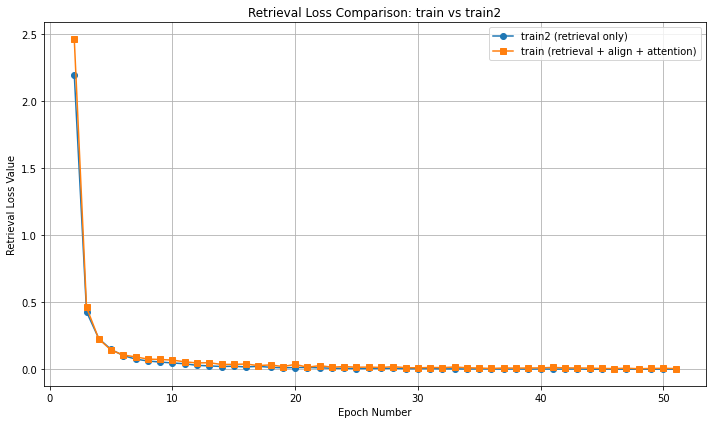


Minimum retrieval loss values:
train.log retrieval loss min: 0.00539 at epoch 48
train2.log retrieval loss min: 0.00135 at epoch 44


In [15]:
# Create plot comparing retrieval losses between train and train2
plt.figure(figsize=(10, 6))
plt.plot(range(2, len(retrieval_losses_train) + 1), retrieval_losses_train[1:], marker='o', label='train2 (retrieval only)')
plt.plot(range(2, len(retrieval_losses_aa) + 1), retrieval_losses_aa[1:], marker='s', label='train (retrieval + align + attention)')

plt.xlabel('Epoch Number')
plt.ylabel('Retrieval Loss Value')
plt.title('Retrieval Loss Comparison: train vs train2')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Print the minimum retrieval loss values for comparison
print("\nMinimum retrieval loss values:")
print(f"train.log retrieval loss min: {min(retrieval_losses_aa[1:])} at epoch {retrieval_losses_aa[1:].index(min(retrieval_losses_aa[1:])) + 2}")
print(f"train2.log retrieval loss min: {min(retrieval_losses_train[1:])} at epoch {retrieval_losses_train[1:].index(min(retrieval_losses_train[1:])) + 2}")



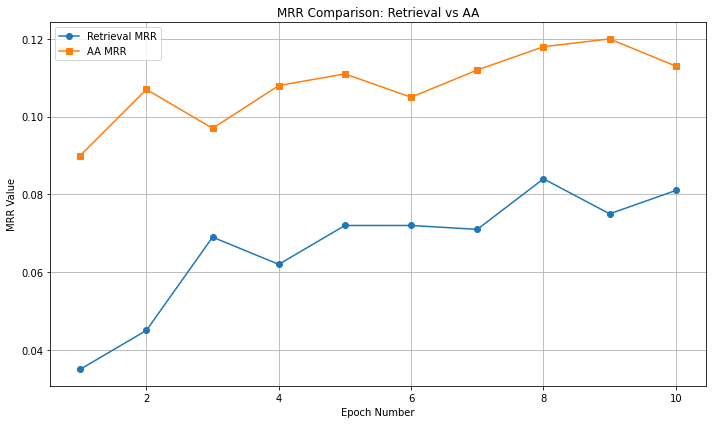


Maximum MRR values:
Retrieval MRR max: 0.084 at epoch 8
AA MRR max: 0.12 at epoch 9


In [10]:
retrieval_mrr = [0.035, 0.045, 0.069, 0.062, 0.072, 0.072, 0.071, 0.084, 0.075, 0.081]
aa_mrr = [0.09, 0.107, 0.097, 0.108, 0.111, 0.105, 0.112, 0.118, 0.120, 0.113]
# Create plot comparing MRR values between retrieval and aa
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(retrieval_mrr) + 1), retrieval_mrr, marker='o', label='Retrieval MRR')
plt.plot(range(1, len(aa_mrr) + 1), aa_mrr, marker='s', label='AA MRR')

plt.xlabel('Epoch Number')
plt.ylabel('MRR Value')
plt.title('MRR Comparison: Retrieval vs AA')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Print the maximum MRR values for comparison
print("\nMaximum MRR values:")
print(f"Retrieval MRR max: {max(retrieval_mrr)} at epoch {retrieval_mrr.index(max(retrieval_mrr)) + 1}")
print(f"AA MRR max: {max(aa_mrr)} at epoch {aa_mrr.index(max(aa_mrr)) + 1}")



In [ ]:
# Read MRR values from train_attention_wo_softmax_retrieval.log
import re
from datetime import datetime

mrr_values = []
epochs = []

log_path = "/inspire/hdd/ws-f4d69b29-e0a5-44e6-bd92-acf4de9990f0/public-project/liuyiming-240108540153/codesearch/train_attention_wo_softmax_retrieval.log"

with open(log_path, 'r') as f:
    for line in f:
        if "eval_mrr =" in line:
            # Extract MRR value using regex
            mrr_match = re.search(r'eval_mrr = ([\d.]+)', line)
            if mrr_match:
                mrr_values.append(float(mrr_match.group(1)))
                
                # Extract epoch number from timestamp
                timestamp = re.search(r'(\d{2}/\d{2}/\d{4} \d{2}:\d{2}:\d{2})', line)
                if timestamp:
                    dt = datetime.strptime(timestamp.group(1), '%m/%d/%Y %H:%M:%S')
                    epochs.append(len(epochs) + 1)  # Just use sequential numbering

# Create plot of MRR values
plt.figure(figsize=(10, 6))
plt.plot(epochs, mrr_values, marker='o', label='Attention w/o Softmax MRR')

plt.xlabel('Epoch Number')
plt.ylabel('MRR Value')
plt.title('MRR Values: Attention without Softmax')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Print the maximum MRR value
print("\nMaximum MRR value:")
print(f"Attention w/o Softmax MRR max: {max(mrr_values)} at epoch {mrr_values.index(max(mrr_values)) + 1}")
